In [206]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

# load general packages
import numpy as np
import matplotlib.pyplot as plt

# load modules related to this exercise
import tools 
from model import model_class

import time # For timing speed

plt.rc('font', family='serif')
plt.rc('text', usetex=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this file, we first plot the policy functions for the one dimensional model using finite differences and egm.
We then compare the speed/acurracy tradeoff for EGM and FD.

# Compute Policy Functions

This is for plotting the estimated policy functions from our models

In [209]:
# Setup model
model = model_class()
model.setup()
model.create_grids()

# Setup eta value
val = 2.0
model.par.eta = val

**Finite Difference**

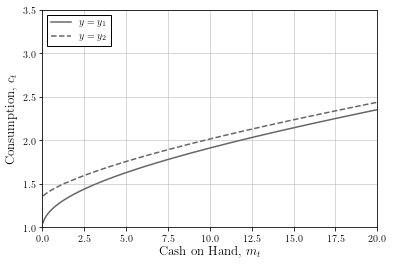

In [210]:
# Solve model
model.par.Nm = 500
model.create_grids()
model.solve_fd()

# Generate figure
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

# Settings
ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.7')
ax.set_xlim([0.0,20])
ax.set_ylim([1.0,3.5])
ax.set_xlabel(r'Cash on Hand, $m_t$', size=13)
ax.set_ylabel(r'Consumption, $c_t$', size=13)

# Plot
ax.plot(model.sol_fd.m[1:],model.sol_fd.c[0,1:], label= r'$y = y_1$', linestyle = '-', color = '0.4')
ax.plot(model.sol_fd.m[1:],model.sol_fd.c[1,1:], label= r'$y = y_2$', linestyle = '--', color = '0.4')

ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False, loc = 2)
plt.savefig('figs/fd_1d_policy.pdf')

**Endogenous grid**

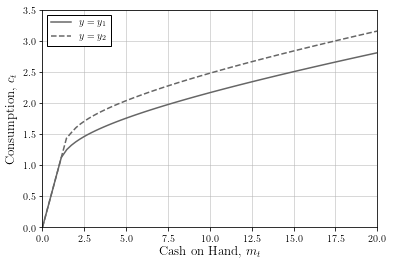

In [107]:
model.create_grids()
model.solve_egm()

# Generate figure
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

# Settings
ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.7')
ax.set_xlim([0.0,20])
ax.set_ylim([.0,3.5])
ax.set_xlabel(r'Cash on Hand, $m_t$', size=13)
ax.set_ylabel(r'Consumption, $c_t$', size=13)

# Plot
ax.plot(model.sol_egm.m[0,:],model.sol_egm.c[0,:], label= r'$y = y_1$', linestyle = '-', color = '0.4')
ax.plot(model.sol_egm.m[1,:],model.sol_egm.c[1,:], label= r'$y = y_2$', linestyle = '--', color = '0.4')

ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)
plt.savefig('figs/egm_1d_policy.pdf')

# Compare Computer Time

### Generate the 'true' policy functions

Setup model

In [203]:
# Maximum grid points is 4000 right now
max_nr = 3500
m_max = 20

# grid = [200, 400, 800, 1000, 1000, 1500, 2000, 2500, 3000, 4000, 5000, 6000, 7000]

**Run VFI**

In [204]:
# Compute policy functions
model.par.Nm = max_nr # Set number
model.m_max = m_max

model.create_grids()
model.solve_vfi()
c_vfi_tr = model.sol_vfi.c

# Save fine asset grid for later interpolation
m_vfi_tr = model.par.grid_m

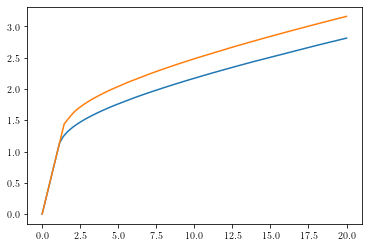

In [205]:
plt.plot(m_vfi_tr, c_vfi_tr[0])
plt.plot(m_vfi_tr, c_vfi_tr[1])
plt.show()

**Run EGM**

In [160]:
# Compute policy functions
model.par.Na = max_nr-1 # Set number
model.m_max = m_max

model.create_grids()
model.solve_egm()
c_egm_tr = model.sol_egm.c

# Save fine asset grid for later interpolation
m_egm_tr = model.sol_egm.m

**Run FD**

In [151]:
# Compute policy functions
model.par.Nm = max_nr
model.par.m_max = m_max
model.create_grids()
model.solve_fd()
c_fd_tr = model.sol_fd.c[:,1:-1]

# Save fine asset grid for later interpolation
m_fd_tr = model.sol_fd.m[1:-1]

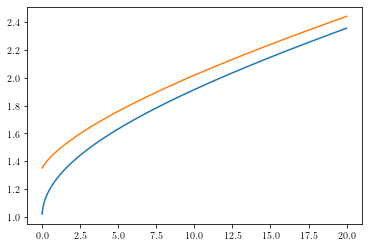

In [152]:
plt.plot(m_fd_tr, c_fd_tr[0])
plt.plot(m_fd_tr, c_fd_tr[1])

Compute the errors

In [161]:
# Points on the grid
num = 50
Na_vec = tools.nonlinspace(50,2000,num,1.3)

# Initialize result vectors
error_egm = np.nan + np.zeros(num)
time_egm = np.nan + np.zeros(num)

for i,Na in enumerate(Na_vec):
    
    # Setup model
    model = model_class()
    model.setup()
    model.par.Na = int(Na) # Set number of gridpoints
    model.create_grids()

    # Solve model and set time
    t0 = time.time()
    model.solve_egm()
    t1 = time.time()
    
    time_egm[i] = t1 - t0
    
    c_egm = model.sol_egm.c
    m_egm = model.sol_egm.m

    # Generate interpolated policy function
    c_egm_interp_1 = tools.interp_linear_1d(m_egm[0], c_egm[0], m_egm_tr[0])
    c_egm_interp_2 = tools.interp_linear_1d(m_egm[1], c_egm[1], m_egm_tr[1])
    c_egm_interp = np.vstack((c_egm_interp_1, c_egm_interp_2))

    # Compute calculation error
    error_egm[i] = 100 * 1/max_nr * 1/2 * np.sum(np.abs(c_egm_interp - c_egm_tr)/c_egm_tr)

In [154]:
#### Points on the grid
num = 50
Nm_vec = np.linspace(400,m_max,num,1.3)
n_reps = 10

# Initialize result vectors
error_fd = np.nan + np.zeros((n_reps,num))
time_fd = np.nan + np.zeros((n_reps,num))

for i,Nm in enumerate(Nm_vec):
    for j in range(n_reps):
        
        # Setup model
        model = model_class()
        model.setup()
        model.par.Nm = int(Nm) # Set number of gridpoints
        model.create_grids()

        # Solve model and set time
        t0 = time.time()
        model.solve_fd()
        t1 = time.time()

        time_fd[j,i] = t1 - t0

        c_fd = model.sol_fd.c
        m_fd = model.sol_fd.m

        # Generate interpolated policy function
        c_fd_interp_1 = tools.interp_linear_1d(m_fd, c_fd[0,1:-1], m_fd_tr)
        c_fd_interp_2 = tools.interp_linear_1d(m_fd, c_fd[1,1:-1], m_fd_tr)
        c_fd_interp = np.vstack((c_fd_interp_1, c_fd_interp_2))

        # Compute calculation error
        error_fd[j,i] = 100 * 1/max_nr * 1/2 * np.sum(np.abs(c_fd_interp - c_fd_tr)/c_fd_tr)
        
#         plt.plot(m_fd[1:], c_fd[0,1:])
#         plt.plot(m_fd[1:], c_fd[1,1:])
#         plt.show()
        
#         print('Rep nr ' + str(j))
    
#     print('Vec iteration is ' + str(i))

Rep nr 0
Rep nr 1
Rep nr 2
Rep nr 3
Rep nr 4
Rep nr 5
Rep nr 6
Rep nr 7
Rep nr 8
Rep nr 9
Vec iteration is 0
Rep nr 0
Rep nr 1
Rep nr 2
Rep nr 3
Rep nr 4
Rep nr 5
Rep nr 6
Rep nr 7
Rep nr 8
Rep nr 9
Vec iteration is 1
Rep nr 0
Rep nr 1
Rep nr 2
Rep nr 3
Rep nr 4
Rep nr 5
Rep nr 6
Rep nr 7
Rep nr 8
Rep nr 9
Vec iteration is 2
Rep nr 0
Rep nr 1
Rep nr 2
Rep nr 3
Rep nr 4
Rep nr 5
Rep nr 6
Rep nr 7
Rep nr 8
Rep nr 9
Vec iteration is 3
Rep nr 0
Rep nr 1
Rep nr 2
Rep nr 3
Rep nr 4
Rep nr 5
Rep nr 6
Rep nr 7
Rep nr 8
Rep nr 9
Vec iteration is 4
Rep nr 0
Rep nr 1
Rep nr 2
Rep nr 3
Rep nr 4
Rep nr 5
Rep nr 6
Rep nr 7
Rep nr 8
Rep nr 9
Vec iteration is 5
Rep nr 0
Rep nr 1
Rep nr 2
Rep nr 3
Rep nr 4
Rep nr 5
Rep nr 6
Rep nr 7
Rep nr 8
Rep nr 9
Vec iteration is 6
Rep nr 0
Rep nr 1
Rep nr 2
Rep nr 3
Rep nr 4
Rep nr 5
Rep nr 6
Rep nr 7
Rep nr 8
Rep nr 9
Vec iteration is 7
Rep nr 0
Rep nr 1
Rep nr 2
Rep nr 3
Rep nr 4
Rep nr 5
Rep nr 6
Rep nr 7
Rep nr 8
Rep nr 9
Vec iteration is 8
Rep nr 0
Rep nr 1
R

C:\Users\madsh\OneDrive - University of Copenhagen\Desktop\Dynamic Programming\Term paper\code\github_clone\DynamicProgramming\utility.py:31: RuntimeWarning: invalid value encountered in power
  return u**(-1.0/par.eta)
C:\Users\madsh\OneDrive - University of Copenhagen\Desktop\Dynamic Programming\Term paper\code\github_clone\DynamicProgramming\fd.py:187: RuntimeWarning: invalid value encountered in greater
  If = ssf > 0 #positive drift --> forward difference
C:\Users\madsh\OneDrive - University of Copenhagen\Desktop\Dynamic Programming\Term paper\code\github_clone\DynamicProgramming\fd.py:188: RuntimeWarning: invalid value encountered in less
  Ib = ssb < 0 #negative drift --> backward difference
C:\Users\madsh\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)



Rep nr 1
Rep nr 2
Rep nr 3
Rep nr 4
Rep nr 5
Rep nr 6
Rep nr 7
Rep nr 8
Rep nr 9
Vec iteration is 47
Rep nr 0
Rep nr 1
Rep nr 2
Rep nr 3
Rep nr 4
Rep nr 5
Rep nr 6
Rep nr 7
Rep nr 8
Rep nr 9
Vec iteration is 48
Rep nr 0
Rep nr 1
Rep nr 2
Rep nr 3
Rep nr 4
Rep nr 5
Rep nr 6
Rep nr 7
Rep nr 8
Rep nr 9
Vec iteration is 49


In [162]:
# Compute average
time_fd_av = np.nan + np.zeros(num)
error_fd_av = np.nan + np.zeros(num)
for i,Nm in enumerate(Nm_vec):
    
    time_fd_av = np.sum(time_fd, axis = 0) / n_reps
    error_fd_av = np.sum(error_fd, axis = 0) / n_reps

In [163]:
time_fd_av

array([0.0658143 , 0.07136133, 0.06776063, 0.06843188, 0.07391999,
       0.08209088, 0.08758242, 0.0768446 , 0.08458078, 0.10543878,
       0.11250949, 0.09156706, 0.09255483, 0.08987439, 0.09186275,
       0.09964786, 0.09796085, 0.09911852, 0.11085122, 0.10951192,
       0.11330292, 0.14423046, 0.11811502, 0.11750033, 0.11709237,
       0.16397321, 0.17300701, 0.18833928, 0.18073289, 0.1713964 ,
       0.19659283, 0.21379943, 0.22787058, 0.21669314, 0.21662087,
       0.18774958, 0.16257493, 0.16258297, 0.17295396, 0.17453728,
       0.18601153, 0.29874227, 0.19378154, 0.20185981, 0.206547  ,
       0.236268  , 0.21691611, 0.16496232, 0.13564887, 0.15479996])

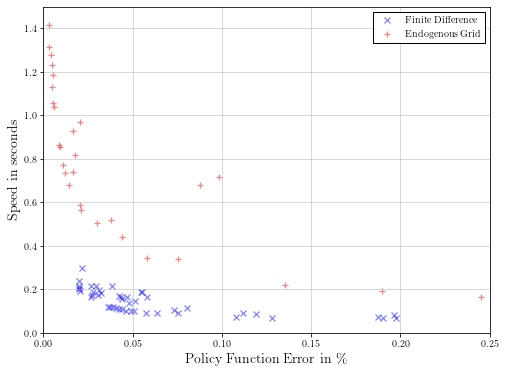

In [183]:
# Generate
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)

# Settings
ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.7')
ax.set_xlim([0.0,0.25])
ax.set_ylim([0,1.5])
ax.set_ylabel(r'Speed in seconds', size=14)
ax.set_xlabel(r'Policy Function Error in \%', size=14)

# ax.set_xscale('log')
# ax.set_xlim([1e-3,2])


# Plot
ax.scatter(error_fd_av,time_fd_av,marker='x', alpha = 0.5, edgecolor = 'k', linewidth=1.2, color = 'blue', label = 'Finite Difference')
ax.scatter(error_egm,time_egm, marker='+', alpha = 0.5, edgecolor = 'k', linewidth=1.2, color = 'red', label = 'Endogenous Grid')

ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)
plt.savefig('figs/tradeoff_1d.pdf')